In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


## Random sample actions: 

In [3]:
env = gym.make("CarRacing-v2", 
               domain_randomize=False, 
               continuous=False) # render_mode="human"
# discrete action space has 5 actions: [do nothing, left, right, gas, brake]

print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space) # nv.action_space is of Discrete class
print("sample action:", env.action_space.sample())
'''
If continuous there are 3 actions :
-0: steering, -1 is full left, +1 is full right
-1: gas
-2: breaking

If discrete there are 5 actions:
-0: do nothing
-1: steer left
-2: steer right
-3: gas
-4: brake
'''

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)
sample action: 2


'\nIf continuous there are 3 actions :\n-0: steering, -1 is full left, +1 is full right\n-1: gas\n-2: breaking\n\nIf discrete there are 5 actions:\n-0: do nothing\n-1: steer left\n-2: steer right\n-3: gas\n-4: brake\n'

(96, 96, 3)


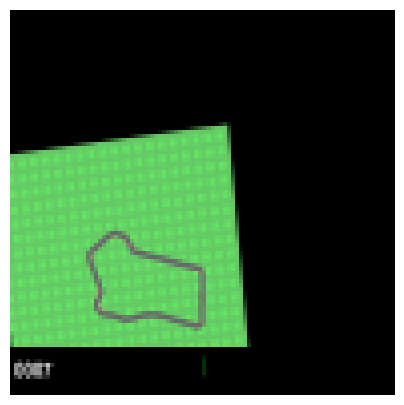

In [4]:
s, info = env.reset()
print(s.shape)

plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

- the game screen gradually zooms in for the first 50 steps, thus, we will not use the first 50 steps of the game.
- In each frame, we cannot guess if the car is moving forward or backward from only one frame, which means we cannot predict the next frame for given the current frame. Thus, we need to stack the previous k=4 frames

- reshape into 84x84
- every frame always contains a black area at the bottom of the frame, so we had better cut this black area.

In [5]:
# resize frames into 84x84
import cv2

def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    # img = cv2.resize(img, dsize=(84, 84)) # or you can simply use rescaling
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

In [6]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        # self.stacked_state 
    
    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        
        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

# Refined environment:

The shape of an observation:  (4, 84, 84)


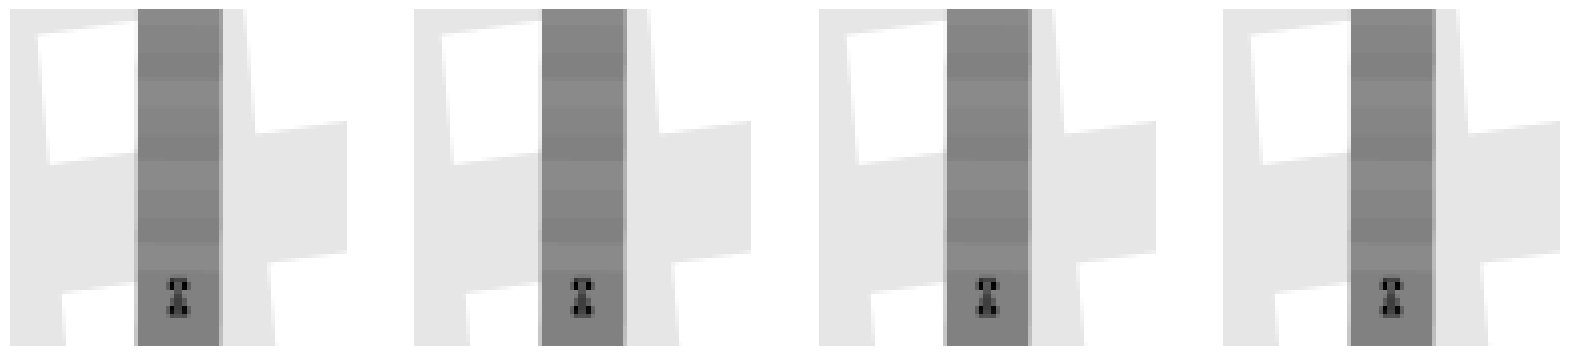

In [7]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

example: do `gas` action for next 4 steps

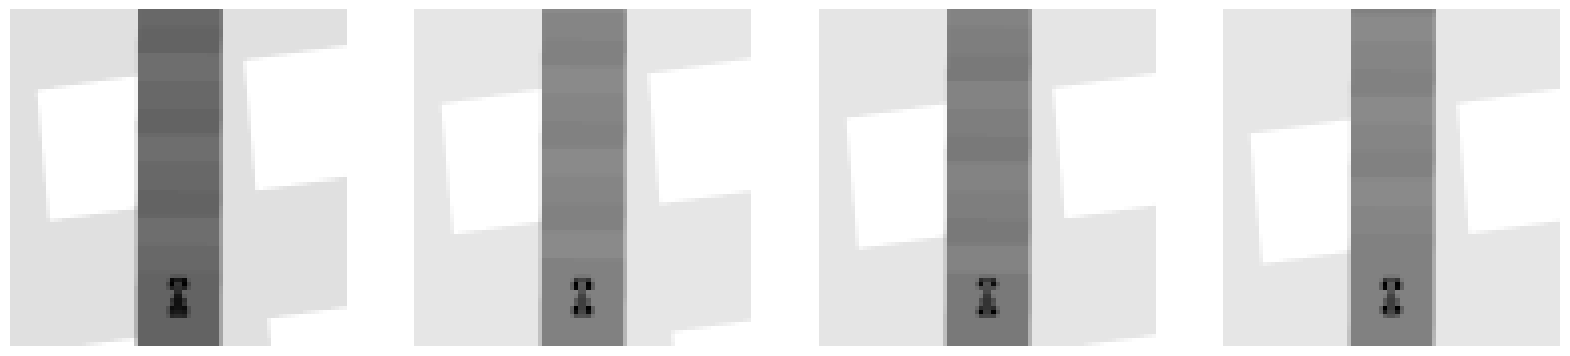

In [8]:
for i in range(10):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Q-network
The input to the neural network consists is an 84 × 84 × 4 image produced by . The first hidden layer convolves 16 8 × 8 filters with stride 4 with the input image and applies a rectifier nonlinearity [10, 18]. The second hidden layer convolves 32 4 × 4 filters with stride 2, again followed by a rectifier nonlinearity. The final hidden layer is fully-connected and consists of 256 rectifier units. The output layer is a fullyconnected linear layer with a single output for each valid action

In [9]:
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)  # [N, 4, 84, 84] -> [N, 16, 20, 20]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.in_features = 32 * 9 * 9
        self.fc1 = nn.Linear(self.in_features, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view((-1, self.in_features))
        x = self.fc1(x)
        x = self.fc2(x) # output shape is [N, action_dim], output is Q-value(s,a)
        return x

# Replay buffer
- The purpose of the ReplayBuffer is to store experiences of the agent as it interacts with the environment using the policy in hand. 
- This allows these experiences to be reused or replayed during the training process. 
- This technique, known as Experience Replay, helps in stabilizing and improving the training process of deep reinforcement learning algorithms.

In [10]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        """Update the buffer with the new transition."""
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        """Randomly sample a batch of experiences from the buffer """
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.s_prime[ind]),
            torch.FloatTensor(self.terminated[ind]), 
        )

# DQN

DQN agent has four methods.

- `__init__()` as usual
- `act()` takes as input one state of np.ndarray and output actions by following epsilon-greedy policy.
- `process()` method takes one transition as input and define what the agent do for each step.
- `learn()` method samples a mini-batch from replay buffer and train q-network

In the DQN paper, they used replay buffer of size 1,000,000 and it requires a huge amount of memory. For epsilon greedy policy, they used the initial epsilon of 1.0 and linearly decrease it to 0.1 for the the first million steps, and fixed it at 0.1 after.

In [11]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=1000, # start updating the model after 1000 steps
        buffer_size=int(1e5),
        target_update_interval=10000, # update the self.network every 10000 steps
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim) # used for action prediction during the learning of self.network
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
        # self.device = torch.device('cpu')
        self.network.to(self.device)
        self.target_network.to(self.device)
        
        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6
    
    @torch.no_grad()
    def act(self, x, training=True):
        """
            Idea:
                training: act with epsilon-greedy policy, involve random actions i.e., exploration
                evaluation: greedy policy, actions totally generated by the network i.e., no exploration
        """
        self.network.train(training)
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.network(x)
            a = torch.argmax(q).item()
        return a
    
    def learn(self):
        """
            Idea: 
                1. fetech random examples from the buffer
                2. calculate the target Q value using self.target_network
                3. predict action using self.target_network and update the self.network
            remark: self.target_network remains unchanged during the learning of self.network
        """
        s, a, r, s_prime, terminated = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))
        
        next_q = self.target_network(s_prime).detach() # the output Q-values for all actions
        td_target = r + (1. - terminated) * self.gamma * next_q.max(dim=1, keepdim=True).values # target for temporal difference learning
        loss = F.mse_loss(self.network(s).gather(1, a.long()), td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.item()
        }
        return result
    
    def process(self, transition):
        """
            Process a new transition and update the model, one consolidated action in a time step
            return: {total_steps, value_loss}
        """
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()
            
        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        self.epsilon -= self.epsilon_decay
        return result
    

# Play a game using the imported DQN Agent

You can choose which model to use by changing the `model_path` variable. The default model is the one trained for 2,000,000 time steps.

## Load in a trained agent 

In [48]:
# choose the model
model_path = 'dqn_2m_1.25km.pt'

#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")
   
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

# default environment settings
state_dim = (4, 84, 84)
action_dim = env.action_space.n

# initialize new agant
def new_agent(state_dim, action_dim):
    try:
        agent = DQN(state_dim, action_dim)
    except Exception as e:
        print(e)
    
    return agent

agent = new_agent(state_dim, action_dim) 
state_dict = torch.load(model_path, map_location=agent.device)
agent.network.load_state_dict(state_dict)

tensor([1.], device='mps:0')


<All keys matched successfully>

## Run the cells below to see the game played by selected agent

In [55]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret
    
video_name = "play_with_agent.webm"  # name for video file
animate(frames, video_name)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [53]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'
